# Shor Algorithm Project

## By: Derek Hines-Mohrman and Quan Ho

In [359]:
import time
import datetime
import math
import numpy as np
import sympy as sp
%matplotlib notebook
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.arithmetic import *
from qiskit import Aer # for simulating circuits
from qiskit.tools.visualization import plot_histogram, plot_bloch_multivector
from qiskit import execute

from qiskit.utils import QuantumInstance
from qiskit.algorithms import Shor
from qiskit.circuit.library import QFT
from qiskit.circuit.library.standard_gates.swap import CSwapGate

from fractions import Fraction

from statistics import mode

# Provided Shor

In [384]:
backend = Aer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
shor = Shor(quantum_instance=quantum_instance)

circ = shor.construct_circuit(N=15, a=13)
circ.draw()

┌───┐┌───────────────┐┌───────┐
  up_0: ┤ H ├┤0              ├┤0      ├
        ├───┤│               ││       │
  up_1: ┤ H ├┤1              ├┤1      ├
        ├───┤│               ││       │
  up_2: ┤ H ├┤2              ├┤2      ├
        ├───┤│               ││       │
  up_3: ┤ H ├┤3              ├┤3      ├
        ├───┤│               ││  IQFT │
  up_4: ┤ H ├┤4              ├┤4      ├
        ├───┤│               ││       │
  up_5: ┤ H ├┤5              ├┤5      ├
        ├───┤│               ││       │
  up_6: ┤ H ├┤6              ├┤6      ├
        ├───┤│               ││       │
  up_7: ┤ H ├┤7              ├┤7      ├
        ├───┤│               │└───────┘
down_0: ┤ X ├┤8              ├─────────
        └───┘│   13^x mod 15 │         
down_1: ─────┤9              ├─────────
             │               │         
down_2: ─────┤10             ├─────────
             │               │         
down_3: ─────┤11             ├─────────
             │               │         
 aux_0: ─────┤12             ├─────────
             │               │         
 aux_1: ─────┤13             ├─────────
             │               │         
 aux_2: ─────┤14             ├─────────
             │               │         
 aux_3: ─────┤15             ├─────────
             │               │         
 aux_4: ─────┤16             ├─────────
             │               │         
 aux_5: ─────┤17             ├─────────
             └───────────────┘

In [ ]:
start_time = time.time()

N = 21
backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=1024)
result = shor.factor(N)

elapsed_time = time.time() - start_time
print("Elapsed time:", datetime.timedelta(seconds=elapsed_time))

In [ ]:
print("Actual number of qubits of circuit: ", shor.construct_circuit(21).num_qubits)

In [ ]:
backend.available_devices()

In [ ]:
print("Factors of", N, ":", result.factors[0])

# Classical Implementation of Shor's Algorithm

In [ ]:
def classical_shor(a, N):
    remainder = 0
    r = 1
    start_time = time.time()
    current_time = start_time
    while ((remainder == 0) or (remainder != 1)):
        remainder = (a**r) % N
        r += 1
        sub_elapsed_time = time.time() - current_time
        if (sub_elapsed_time > 300):
            total_elapsed_time = time.time() - start_time
            print("r=", r, "elapsed time:", datetime.timedelta(seconds=total_elapsed_time))
            current_time = time.time()


    r -= 1

    #print("a=", a, "r=", r, "remainder=", remainder)

    if (r % 2 == 0):
        x = a**(int(r/2)) % N
        if ((x + 1) != (0 % N)):
            x = int(x)
            print("gcd(x+1,N):", math.gcd(x+1,N))
            print("gcd(x-1,N):", math.gcd(x-1,N))
            print("r=", r)
        else:
            print("Try another a")
    else:
        print("Try another a")
        

In [ ]:
def my_randprime(n):
    return sp.randprime(2,2**n)

In [ ]:
#n = 4 # number of bits of prime factors

for n in range(4,20):
    prime_1 = my_randprime(n)
    prime_2 = my_randprime(n)
    N = prime_1 * prime_2
    a = my_randprime(n)
    while (math.gcd(a, N) != 1):
        a = my_randprime(n)
    
    print("n=", n)
    print("N=", N)
    
    start = time.time()
    classical_shor(a, N)
    elapsed_time = time.time() - start

    print("Elapsed time:", datetime.timedelta(seconds=elapsed_time))
    print("---------")

# Quantum Implementation

In [2]:
def myQFT(n, inverse=False, do_swaps=False):
    if (inverse):
        return QFT(num_qubits=n, inverse=True, do_swaps=do_swaps, name='IQFT')
    else:
        return QFT(num_qubits=n, inverse=False, do_swaps=do_swaps, name='QFT')

In [3]:
def ADD(n, a):
    q = QuantumRegister(n, 'q')
    qc = QuantumCircuit(q)

    for i in range(1, n+1):
        phi = ((2*np.pi)/(2**i)) * a
        qc.rz(phi=phi, qubit=q[i-1])
    
    return qc.to_gate(label='ADD')

In [122]:
def CMOD_ADD(n, a, N):
    c = QuantumRegister(2, 'c')
    q = QuantumRegister(n, 'q')
    aux = QuantumRegister(2, 'aux')

    qc = QuantumCircuit(c, q, aux)


    qubit_list = [c[0], c[1]]
    for i in range(n):
        qubit_list.append(q[i])
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, a).control(2), qubit_list)
    
    qubit_qft = []
    for i in range(n):
        qubit_qft.append(q[i])
    qubit_qft.append(aux[0])
    
    qc.append(ADD(n+1, N).inverse(), qubit_qft)

    iqft0 = myQFT(n+1, inverse=True)
    qc.append(iqft0, qubit_qft)

    qc.cx(aux[0], aux[1])

    qft1 = myQFT(n+1)
    qc.append(qft1, qubit_qft)

    qubit_list = [aux[1]]
    for i in range(n):
        qubit_list.append(q[i])
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, N).control(1), qubit_list)

    # for cleaning aux


    qubit_list = [c[0], c[1]]
    for i in range(n):
        qubit_list.append(q[i]) 
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, a).inverse().control(2), qubit_list)

    iqft1 = myQFT(n+1, inverse=True)
    qc.append(iqft1, qubit_qft)

    qc.x(aux[0])
    qc.cx(aux[0], aux[1])
    qc.x(aux[0])

    qft2 = myQFT(n+1)
    qc.append(qft2, qubit_qft)

    qubit_list = [c[0], c[1]]
    for i in range(n):
        qubit_list.append(q[i]) 
    qubit_list.append(aux[0])

    qc.append(ADD(n+1, a).control(2), qubit_list)

    
    return qc.to_instruction(label='CMOD_ADD')
    
    

In [304]:
def CMULT(n, a, N):
    b = QuantumRegister(n, 'b')
    x = QuantumRegister(n, 'x')
    aux = QuantumRegister(2, 'aux')
    c = QuantumRegister(1, 'c')

    # create a list of qubits to pass as qargs into append(controlled MOD_ADD)
    # append can't seem to recognize [q, aux] as n+1 bits

    
    qubit_madd = [c[0]]
    for i in range(n):
        qubit_madd.append(b[i])
    qubit_madd.append(aux[0])
    qubit_madd.append(aux[1])

    qc = QuantumCircuit(c, x, b, aux)
    
    qubit_qft = []
    for i in range(n):
        qubit_qft.append(b[i])
    qubit_qft.append(aux[0])
    
    qft_init = myQFT(n+1)
    qc.append(qft_init, qubit_qft)

    for i in range(n):
        qubit_cmadd = qubit_madd.copy()
        qubit_cmadd.insert(1, x[i])
        qc.append(CMOD_ADD(n, (2**i)*a % N, N), qubit_cmadd)
        
    iqft_last = myQFT(n+1, inverse=True)
    qc.append(iqft_last, qubit_qft)
        
        
    return qc.to_instruction(label='CMULT')



In [395]:
def U(n, a, i, N):
    label = "U()" + str(a) + "^(2^" + str(i) + ")"  

    a = a**(2**i)
    
    x = QuantumRegister(n, 'x')
    b = QuantumRegister(n, 'b')
    aux = QuantumRegister(2, 'aux')
    c = QuantumRegister(1, 'c')

    qc = QuantumCircuit(c, x, b, aux)
    
    qubit_mult = [c[0]]
    for i in range(n):
        qubit_mult.append(x[i])
    for i in range(n):
        qubit_mult.append(b[i])
    qubit_mult.append(aux[0])
    qubit_mult.append(aux[1])

    qc.append(CMULT(n, a, N), qubit_mult)

    for i in range(n):
        qc.append(CSwapGate(), [c[0], x[i], b[i]])

    a_inv = pow(a, -1, N)
    qc.append(CMULT(n, a_inv, N).inverse(), qubit_mult)
    
    return qc.to_instruction(label=label)


In [407]:
n = 4
N = 21

a = 11  
x_val = 1

In [408]:
x = QuantumRegister(2*n, 'x')
w = QuantumRegister(n, 'w')
b = QuantumRegister(n, 'b')
aux = QuantumRegister(2, 'aux')

        
cl_x = ClassicalRegister(2*n, 'cl_x')


qc = QuantumCircuit(x, w, b, aux)
qc.add_register(cl_x)

qc.h(x)
qc.x(w[0])

qubit_u = []
for i in range(n):
    qubit_u.append(w[i])
for i in range(n):
    qubit_u.append(b[i])
qubit_u.append(aux[0])
qubit_u.append(aux[1])

for i in range(2*n):
    qubit_u_single = qubit_u.copy()
    qubit_u_single.insert(0, x[2*n-1-i])
    qc.append(U(n, a, i, N), qubit_u_single)

    
qc.append(myQFT(2*n, inverse=True), x)

qc.measure(x, cl_x)

qc.draw()

┌───┐                                                   »
   x_0: ┤ H ├───────────────────────────────────────────────────»
        ├───┤                                                   »
   x_1: ┤ H ├───────────────────────────────────────────────────»
        ├───┤                                                   »
   x_2: ┤ H ├───────────────────────────────────────────────────»
        ├───┤                                                   »
   x_3: ┤ H ├───────────────────────────────────────────────────»
        ├───┤                                                   »
   x_4: ┤ H ├───────────────────────────────────────────────────»
        ├───┤                                  ┌───────────────┐»
   x_5: ┤ H ├──────────────────────────────────┤0              ├»
        ├───┤                 ┌───────────────┐│               │»
   x_6: ┤ H ├─────────────────┤0              ├┤               ├»
        ├───┤┌───────────────┐│               ││               │»
   x_7: ┤ H ├┤0              ├┤               ├┤               ├»
        ├───┤│               ││               ││               │»
   w_0: ┤ X ├┤1              ├┤1              ├┤1              ├»
        └───┘│               ││               ││               │»
   w_1: ─────┤2              ├┤2              ├┤2              ├»
             │               ││               ││               │»
   w_2: ─────┤3              ├┤3              ├┤3              ├»
             │               ││               ││               │»
   w_3: ─────┤4              ├┤4              ├┤4  U()11^(2^2) ├»
             │               ││   U()11^(2^1) ││               │»
   b_0: ─────┤5  U()11^(2^0) ├┤5              ├┤5              ├»
             │               ││               ││               │»
   b_1: ─────┤6              ├┤6              ├┤6              ├»
             │               ││               ││               │»
   b_2: ─────┤7              ├┤7              ├┤7              ├»
             │               ││               ││               │»
   b_3: ─────┤8              ├┤8              ├┤8              ├»
             │               ││               ││               │»
 aux_0: ─────┤9              ├┤9              ├┤9              ├»
             │               ││               ││               │»
 aux_1: ─────┤10             ├┤10             ├┤10             ├»
             └───────────────┘└───────────────┘└───────────────┘»
cl_x: 8/════════════════════════════════════════════════════════»
                                                                »
«                                                                            »
«   x_0: ────────────────────────────────────────────────────────────────────»
«                                                           ┌───────────────┐»
«   x_1: ───────────────────────────────────────────────────┤0              ├»
«                                          ┌───────────────┐│               │»
«   x_2: ──────────────────────────────────┤0              ├┤               ├»
«                         ┌───────────────┐│               ││               │»
«   x_3: ─────────────────┤0              ├┤               ├┤               ├»
«        ┌───────────────┐│               ││               ││               │»
«   x_4: ┤0              ├┤               ├┤               ├┤               ├»
«        │               ││               ││               ││               │»
«   x_5: ┤               ├┤               ├┤               ├┤               ├»
«        │               ││               ││               ││               │»
«   x_6: ┤               ├┤               ├┤               ├┤               ├»
«        │               ││               ││               ││               │»
«   x_7: ┤               ├┤               ├┤               ├┤               ├»
«        │               ││               ││               ││               │»
«   w_0: ┤1              ├┤1              ├┤1              ├┤1              ├»
«        │  

[('10000000', 109), ('00000000', 95), ('01010101', 75), ('00101011', 75), ('10101011', 70), ('11010101', 68), ('10101010', 27), ('01010110', 16), ('11010110', 15), ('00101010', 13), ('11010011', 12), ('00101100', 11), ('11010100', 11), ('10101100', 10), ('11101011', 10), ('01101011', 9), ('01010100', 8), ('01010011', 8), ('11000000', 8), ('10101000', 7), ('01111110', 7), ('00101101', 7), ('11100101', 6), ('10101001', 6), ('01000000', 6), ('10001000', 6), ('01111111', 6), ('01001011', 6), ('11010000', 6), ('10101101', 6), ('01001101', 6), ('00000001', 5), ('01011000', 5), ('11111110', 5), ('01111100', 5), ('00101001', 4), ('00110011', 4), ('10110011', 4), ('10001010', 4), ('10010101', 4), ('10100101', 4), ('00001000', 4), ('10101111', 4), ('00001011', 4), ('01010000', 4), ('00101000', 4), ('10110000', 4), ('01111000', 4), ('10110101', 4), ('10100000', 4), ('11110101', 4), ('00110101', 3), ('11001101', 3), ('10011011', 3), ('00100101', 3), ('11001011', 3), ('11100000', 3), ('11101100', 3

<IPython.core.display.Javascript object>


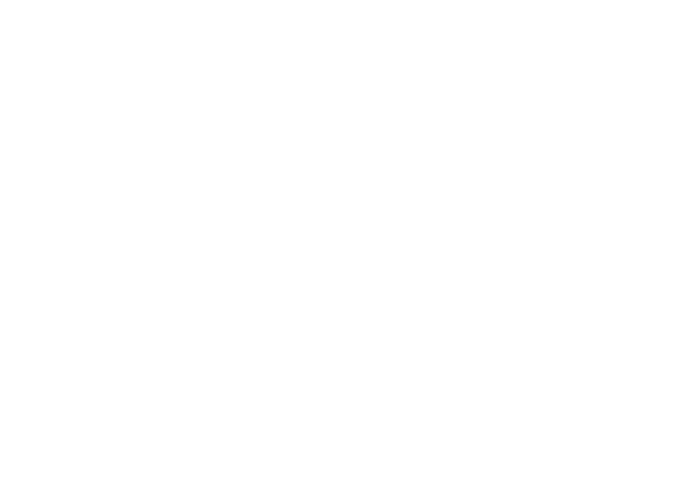

<IPython.core.display.Javascript object>


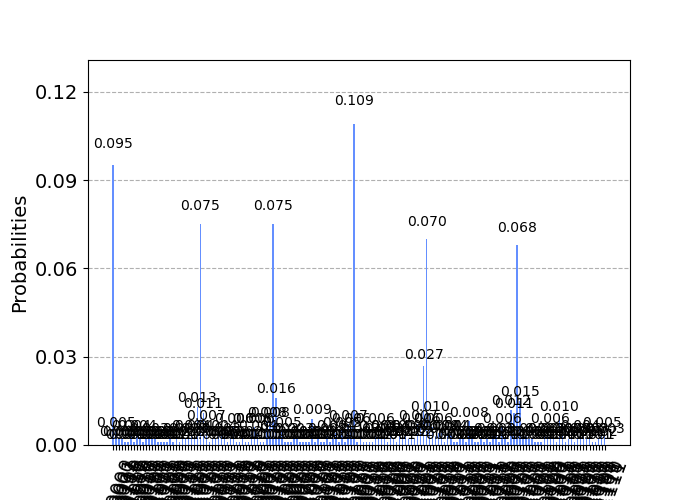

In [409]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)
result = job.result()

counts = result.get_counts()
sort_counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

print(sort_counts)
plot_histogram(counts)

In [411]:
# extract the guesses for order r from quantum algorithm

output = list(result.data()['counts'].keys())
output = [int(x, 16) for x in output]
print("Output:", output)

output = [x/(2**(2*n)) for x in output]
guess = []
for x in output:
    s_r = Fraction(x)
    r = 1
    if (x != 0):
        r = int(s_r.denominator)
    guess.append(r) 
print("Guess for r:", guess)

Output: [41, 229, 169, 0, 85, 139, 170, 128, 231, 206, 53, 43, 44, 205, 155, 186, 84, 194, 37, 59, 118, 211, 239, 213, 171, 1, 168, 42, 126, 64, 47, 136, 83, 191, 32, 214, 66, 51, 45, 172, 237, 179, 88, 138, 188, 86, 46, 203, 224, 67, 127, 119, 75, 149, 236, 193, 208, 117, 130, 34, 165, 192, 235, 247, 8, 173, 87, 187, 97, 107, 98, 253, 252, 21, 163, 254, 30, 123, 248, 28, 175, 255, 11, 80, 212, 215, 201, 116, 74, 77, 33, 63, 40, 176, 29, 222, 96, 167, 120, 152, 89, 216, 48, 135, 91, 183, 90, 228, 148, 181, 39, 160, 125, 22, 174, 3, 245, 209, 19, 240, 243, 27, 7, 70, 124, 131, 234, 195, 178, 221, 244, 25, 251, 197, 144, 129, 81, 246, 115, 20, 153, 4, 38, 217, 16, 156, 109, 60, 202, 219, 69, 35, 220, 210, 108, 104, 106, 6, 199, 134, 132, 101, 10, 82]
Guess for r: [256, 256, 256, 1, 256, 256, 128, 2, 256, 128, 256, 256, 64, 256, 256, 128, 64, 128, 256, 256, 128, 256, 256, 256, 256, 256, 32, 128, 128, 4, 256, 32, 256, 256, 8, 128, 128, 256, 256, 64, 256, 256, 32, 128, 64, 128, 128, 256, 8,

In [412]:
# find possible factors of N

# choose r
r = mode(guess)

# try to find factors
if (r % 2 == 0):
    x = a**(int(r/2)) % N
    if ((x + 1) != (0 % N)):
        x = int(x)
        guess_factor_1 = math.gcd(x+1,N)
        guess_factor_2 = math.gcd(x-1,N)
        print("gcd(x+1,N):", guess_factor_1)
        print("gcd(x-1,N):", guess_factor_2)
        print("r=", r)
    else:
        print("Try another a")
else:
    print("Try another a")


if ((guess_factor_1 != 1) and (N % guess_factor_1 == 0)):
    final_factor_1 = guess_factor_1
    final_factor_2 = int(N / guess_factor_1)
else:
    final_factor_2 = guess_factor_2
    final_factor_1 = int(N / guess_factor_2)
    
print("Factors of N:", "[", final_factor_1, ",", final_factor_2, "]")

gcd(x+1,N): 1
gcd(x-1,N): 3
r= 256
Factors of N: [ 7 , 3 ]
